<a href="https://colab.research.google.com/github/Vaskisetkielet/learning-training/blob/main/Logistic_regression_%26_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [517]:
import pandas as pd
import numpy as np
import random
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sympy import *

# Логистическая регрессия

Логистическая регрессия - это модель, используемая для прогнозирования вероятности некоторого события путём его сравнения с логистической кривой. При этом подразумевается, что пространство вероятностей можно разделить линейной границей. Почему для прогнозирования используется кривая, а не прямая, как в линейной регрессии? Ответ на этот вопрос дан ниже.

# Построение модели

Для начала сформируем выборку из `x` и `y`, где `x` является случайным нормализированным числом, а `y` - значением 0 или 1 и посмотрим её графическую репрезентацию.

In [518]:
def create_logist_regr():
  len_of_array = 50
  noise = np.random.normal(0,1,len_of_array)
  sign = random.choice([-1,1])
  a0 = random.randint(-2,2) + random.random() * sign
  b0 = random.randint(0,4) + random.random() * sign

  x = np.random.uniform(1,20,len_of_array)
  y = a0 * x + b0 + noise
  y = np.array([1 if i > np.median(y) else 0 for i in y])
  return x,y

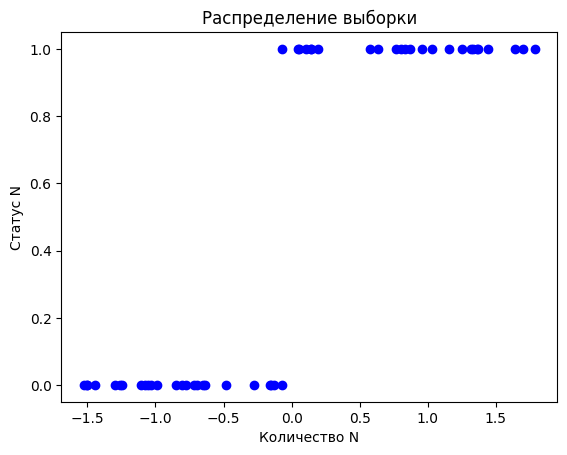

In [519]:
x, y = create_logist_regr()
scaler = StandardScaler()
x = x.reshape(-1,1)
x = scaler.fit_transform(x)
x = x.ravel()
x, y = sorted(x), sorted(y)

plt.scatter(x,y,c='b')
plt.title('Распределение выборки')
plt.xlabel('Количество N')
plt.ylabel('Статус N')
df = pd.DataFrame({"x":x,"y":y})

Теперь попробуем обучить на этих данных модель линейной регрессии.

In [520]:
a, b = 1, 1
n = 101
nu = 0.1
df['pred'] = a * df['x'] + b
for i in range(n):
  df['err'] = df['y'] - df['pred']
  df['a_change'] = df['x'] * np.sign(df['err'])
  df['b_change'] = np.sign(df['err'])

  a += nu * df['a_change'].mean()
  b += nu * df['b_change'].mean()

  df['pred'] = a *df['x'] + b
  df['err'] = df['y'] - df['pred']
  df['err_abs'] = np.abs(df['err'])
  if i%5 == 0:
    print(f'Для итерации {i} абсолютная ошибка равна {df["err_abs"].mean():.4f}')

Для итерации 0 абсолютная ошибка равна 0.5665
Для итерации 5 абсолютная ошибка равна 0.3647
Для итерации 10 абсолютная ошибка равна 0.2265
Для итерации 15 абсолютная ошибка равна 0.2050
Для итерации 20 абсолютная ошибка равна 0.2032
Для итерации 25 абсолютная ошибка равна 0.2032
Для итерации 30 абсолютная ошибка равна 0.2032
Для итерации 35 абсолютная ошибка равна 0.2032
Для итерации 40 абсолютная ошибка равна 0.2032
Для итерации 45 абсолютная ошибка равна 0.2032
Для итерации 50 абсолютная ошибка равна 0.2033
Для итерации 55 абсолютная ошибка равна 0.2032
Для итерации 60 абсолютная ошибка равна 0.2032
Для итерации 65 абсолютная ошибка равна 0.2033
Для итерации 70 абсолютная ошибка равна 0.2032
Для итерации 75 абсолютная ошибка равна 0.2032
Для итерации 80 абсолютная ошибка равна 0.2032
Для итерации 85 абсолютная ошибка равна 0.2032
Для итерации 90 абсолютная ошибка равна 0.2032
Для итерации 95 абсолютная ошибка равна 0.2033
Для итерации 100 абсолютная ошибка равна 0.2032


Здесь линейная регрессия быстро находит оптимальные параметры, но всё ещё сохраняет значительную ошибку. Визуальная репрезентация будет выглядеть так:

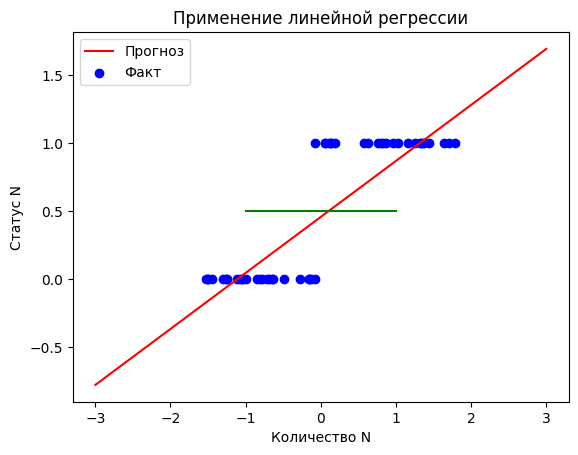

In [521]:
x = np.linspace(-3,3, num=1000)
plt.title('Применение линейной регрессии')
plt.xlabel('Количество N')
plt.ylabel('Статус N')

plt.plot(x, a * x + b, c='r', label = 'Прогноз')
plt.scatter(df['x'], df['y'], c='b', label = 'Факт')
plt.plot([-1,1],[0.5,0.5],c='g')
plt.legend()

Как видно из графика выше, при построении линейной регрессии мы можем получить очень большие или очень маленькие значения `y`. При, скажем, `x` равном -3, `y` будет равняться -0,5, что не совсем удобно переводить в вероятность. Можно, конечно, принять, что все значения до определенной границы относятся к `y=0`, а после - к `y=1` (зеленая линия на графике),

Но есть более удобный вариант - применить формулу сигмоиды для расчета значения прогноза, тогда мы будем на выходе получать значение вероятности от 0 до 1.

Таким образом, линейная регрессия показывает предполагаемое значение зависимой величины, а логистическая регрессия — вероятность, что величина примет одно из двух бинарных значений.

На графике это будет выглядеть так (он интерактивный, можно менять наборы параметров):


In [522]:
from ipywidgets import interactive

def f(a,b):
  plt.figure(2)
  x = np.linspace(-3,3, num=1000)
  plt.grid()
  plt.plot(df['x'], 1/(1+np.exp(-(a * df['x'] + b))), c='r')
  plt.scatter(df['x'], df['y'], c='b')

interactive_plot = interactive(f, a=(-3.0,3.0), b=(-3,3,0.5))
output = interactive_plot.children[-1]
output.layout.height = '420px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='a', max=3.0, min=-3.0), FloatSlider(value=0.0, descr…

Теперь выведем производную из функции ошибки (`у-сигмоида`)

In [523]:
x_ = Symbol('x', real=True)
y_ = Symbol('y', real=True)
a_ = Symbol('a', real=True)
b_ = Symbol('b', real=True)

In [524]:
e = Abs(y_ - 1/(1+exp(-a_*x_-b_)))


In [525]:
str(e)

'Abs(y - 1/(exp(-a*x - b) + 1))'

In [526]:
str(diff(e,a_))

'-x*exp(-a*x - b)*sign(y - 1/(exp(-a*x - b) + 1))/(exp(-a*x - b) + 1)**2'

In [527]:
str(diff(e,b_))

'-exp(-a*x - b)*sign(y - 1/(exp(-a*x - b) + 1))/(exp(-a*x - b) + 1)**2'

И применим эту формулу для выражения выше, чтобы посчитать логистическую регрессию и оптимизировать её с помощью найденного (анти)градиента.

In [528]:
df = df[['x', 'y']].copy()
a, b = 1, 1
n = 501
nu = 0.1
df['pred'] = 1/(1+np.exp(-(a * df['x'] + b)))
for i in range(n):
  df['err'] = df['y'] - df['pred']

  df['a_change'] = df['x']*np.exp(-a*df['x'] - b)*np.sign(df['y'] - 1/(np.exp(-a*df['x'] - b) + 1))/(np.exp(-a*df['x'] - b) + 1)**2
  df['b_change'] = np.exp(-a*df['x'] - b)*np.sign(df['y'] - 1/(np.exp(-a*df['x'] - b) + 1))/(np.exp(-a*df['x'] - b) + 1)**2

  a += nu * df['a_change'].mean()
  b += nu * df['b_change'].mean()

  df['pred'] = 1/(1+np.exp(-(a * df['x'] + b)))

  df['err'] = df['y'] - df['pred']
  df['err_abs'] = np.abs(df['err'])
  if i%50 == 0:
    print(f"Абсолютная ошибка логистической регрессии для итерации {i} равна {df['err_abs'].mean():.4f}")

Абсолютная ошибка логистической регрессии для итерации 0 равна 0.3386
Абсолютная ошибка логистической регрессии для итерации 50 равна 0.2451
Абсолютная ошибка логистической регрессии для итерации 100 равна 0.1966
Абсолютная ошибка логистической регрессии для итерации 150 равна 0.1707
Абсолютная ошибка логистической регрессии для итерации 200 равна 0.1550
Абсолютная ошибка логистической регрессии для итерации 250 равна 0.1444
Абсолютная ошибка логистической регрессии для итерации 300 равна 0.1366
Абсолютная ошибка логистической регрессии для итерации 350 равна 0.1307
Абсолютная ошибка логистической регрессии для итерации 400 равна 0.1259
Абсолютная ошибка логистической регрессии для итерации 450 равна 0.1219
Абсолютная ошибка логистической регрессии для итерации 500 равна 0.1186


Как можно увидеть, абсолютная ошибка также уменьшилась. Сравним её с моделью SKLearn-a:

In [529]:
logreg = LogisticRegression()
logreg.fit(df[['x']], df['y'])
df['lr_pred'] = logreg.predict_proba(df[['x']])[:,1]

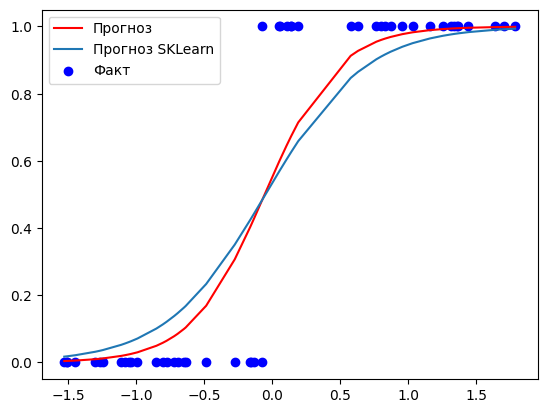

In [530]:
plt.plot(df['x'], df['pred'], c='r', label = 'Прогноз')
plt.plot(df['x'], df['lr_pred'], label = 'Прогноз SKLearn')

plt.scatter(df['x'], df['y'], c='b', label = 'Факт')
plt.legend()

И найдем ROC-AUC score для обеих моделей (что это см. ниже).

In [531]:
print(roc_auc_score(df['y'], df['pred']))
print(roc_auc_score(df['y'], df['lr_pred']))

1.0
1.0


# Описание метода максимального правдоподобия как функции ошибки для логистической регрессии

В логистической регрессии в качестве функции потерь используют метод максимального правдоподобия, а не MSE или AE/RMSE.

Для логистической регрессии функция ошибки будет иметь вид:
- для `y = 1`:
$p(y_1) * p(y_2) * p(y_3)... * p(y_n)$
- для `y = 0`:
$(1-p(y_1)) * (1-p(y_2)) * (1-p(y_3))... * (1-p(y_n))$

После чего получившиеся произведения перемножаются.
Для того, чтобы избежать умножения и получения в результате числа с очень большим числом нулей после запятой берут логарифм. Получившаяся функция со знаком минус называется **Logloss**. Выглядит это так:

$-\Sigma^{n}_{i=1}  y * log(p) + (1-y) * log(1-p)$.

Так как нам нужно идти в обратную сторону от направления скорейшего роста - мы убираем минус из начала выражения.
По этой формуле если `y = 1`, то остается только правая часть выражения, если `y = 0` - левая.

`p` в данном случае - функция сигмоиды с определенным набором параметров `a` и `b`.
Таким образом, для логистической регрессии функция принимает вид

$\Sigma^{n}_{i=1}  y * log(\frac{1}{1+e^{-ax-b}}) + (1-y) * log(1-\frac{1}{1+e^{-ax-b}})$.

Для функции ошибки в данном случае требуется её максимизация.

Производная этой фукции по a:

$\frac{x(e^{ax+b}(-1+y)+y)}{1+e^{ax+b}}$

Ошибка в данном случае имеет вид $y - \frac{1}{1+e^{-ax-b}}$

При делении верхнего выражения на нижнее получается `x`. Т.е. Производная ошибки по `a` равна $x * (y - \frac{1}{1+e^{-ax-b}})$.

По b всё то же самое, только без x в начале $(y - \frac{1}{1+e^{-ax-b}})$.

Таким образом, формулы для обновления a_change и b_change будут выглядеть следующим образом:

```
df['a_change'] = df['x'] * df['err']
df['b_change'] = np.sign(df['err'])
```
Применим полученные формулы для нашей логистической регрессии:


In [532]:
df = df[['x', 'y']].copy()
a, b = 1, 1
n = 501
nu = 0.05
df['pred'] = 1/(1+np.exp(-(a * df['x'] + b)))

for i in range(n):
  df['err'] = df['y'] - df['pred']

  df['a_change'] = df['x']*df['err']
  df['b_change'] = df['err']

  a += nu * df['a_change'].mean()
  b += nu * df['b_change'].mean()

  df['pred'] = 1/(1+np.exp(-(a * df['x'] + b)))

  df['err'] = df['y'] - df['pred']
  df['err_abs'] = np.abs(df['err'])
  df['l'] = df['y']*(np.log(df['pred'])) + (1-df['y'])*(np.log(1-df['pred']))
  if i%50 == 0:
    print(f"Logloss для итерации {i} равен {df['l'].sum():.4f}")


Logloss для итерации 0 равен -23.6595
Logloss для итерации 50 равен -16.2559
Logloss для итерации 100 равен -13.2624
Logloss для итерации 150 равен -11.7001
Logloss для итерации 200 равен -10.7302
Logloss для итерации 250 равен -10.0560
Logloss для итерации 300 равен -9.5506
Logloss для итерации 350 равен -9.1518
Logloss для итерации 400 равен -8.8252
Logloss для итерации 450 равен -8.5506
Logloss для итерации 500 равен -8.3147


И сравним её с прогнозом SKLearn-a:

In [533]:
logreg = LogisticRegression(max_iter=500)
logreg.fit(df[['x']], df['y'])
df['lr_pred'] = logreg.predict_proba(df[['x']])[:,1]
df['l_s'] = df['y']*(np.log(df['lr_pred'])) + (1-df['y'])*(np.log(1-df['lr_pred']))
print(f"Logloss SKLearn равен {df['l_s'].sum():.4f}")

Logloss SKLearn равен -9.2749


После чего построим график обеих функций.

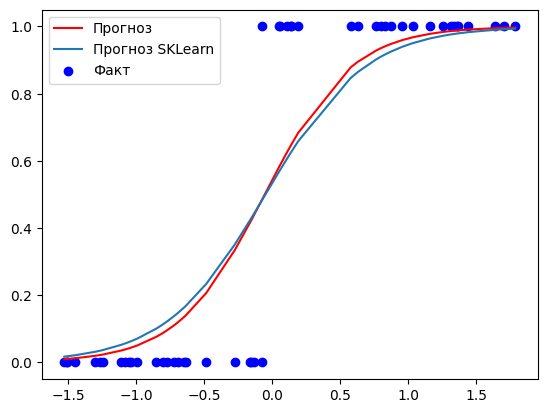

In [534]:
plt.plot(df['x'], df['pred'], c='r', label = 'Прогноз')
plt.plot(df['x'], df['lr_pred'], label = 'Прогноз SKLearn')

plt.scatter(df['x'], df['y'], c='b', label = 'Факт')
plt.legend()

Как можно увидеть, модели получились очень близкими.

# Метрики

## Accuracy, precision, recall, F1 score

Всё будет рассчитано для указанной выше модели.

In [535]:
df['y_pred'] = df['lr_pred'].apply(round)

In [536]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
#Work in progress

## ROC AUC, PR AUC